In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A resistor devider is needed to lower the voltage level of the amplifier command voltage used for lab 4 to a lower voltage. The input voltage is:

In [2]:
Vin = 3.3 # Volts

The desired current is:

In [3]:
Iout = 0.05 # Amps

Since the amplifier gain is:

In [4]:
Ka = 0.06 # A / V

Therefore, the desired voltage is:

In [5]:
Vout = Iout / Ka
print(f"{Vout} Volts")

0.833333333333333 Volts


The hard part about this design problem is the resistor choices are limited. Resistors are primarily only available in the E-series:

In [6]:
Eseries = np.array([1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

@np.vectorize
def find_closest(value):
  series = np.hstack([Eseries, 10 * Eseries])
  while True:
    if value > series.max():
      series *= 10
    elif value < series.min():
      series /= 10
    else:
      break
  return series[np.abs(series - value).argmin()]
  

We can assume values for R2, then solve for R1.

In [7]:
R2 = np.hstack([100 * Eseries, 1000 * Eseries])
R2

array([ 100.,  120.,  150.,  180.,  220.,  270.,  330.,  390.,  470.,
        560.,  680.,  820., 1000., 1200., 1500., 1800., 2200., 2700.,
       3300., 3900., 4700., 5600., 6800., 8200.])

There is an extra 100k resistor built into the amplifier that will be parallel to R2. Taking this into account:

In [8]:
R2_act = 1 / (1 / R2 + 1 / 100000)
R2_act

array([  99.9000999 ,  119.85617259,  149.77533699,  179.67658215,
        219.51706246,  269.272963  ,  328.91458188,  388.48490886,
        467.80133373,  556.8814638 ,  675.40723083,  813.33068836,
        990.0990099 , 1185.77075099, 1477.83251232, 1768.17288802,
       2152.64187867, 2629.01655307, 3194.57889642, 3753.60923965,
       4489.01623687, 5303.03030303, 6367.0411985 , 7578.55822551])

We can now solve for the value of the R1, given R2:

In [9]:
def solve_divider(R2):
  return R2 * (Vin / Vout - 1)

In [10]:
R1 = find_closest(solve_divider(R2_act))
print(R1)

[  270.   330.   470.   560.   680.   820.  1000.  1200.  1500.  1500.
  1800.  2200.  2700.  3300.  4700.  5600.  6800.  8200. 10000. 12000.
 12000. 15000. 18000. 22000.]


We can now find the output of each divider:

In [11]:
Vout_act = Vin * (R2_act / (R1 + R2_act))
Vout_act

array([0.89124153, 0.87922628, 0.79748028, 0.80161078, 0.80532803,
       0.8157742 , 0.81677042, 0.80705847, 0.78450216, 0.89344421,
       0.90039483, 0.89070585, 0.88543064, 0.87232355, 0.78941073,
       0.79191553, 0.79347731, 0.80115813, 0.79897285, 0.78629032,
       0.8984013 , 0.8619403 , 0.86228097, 0.84551931])

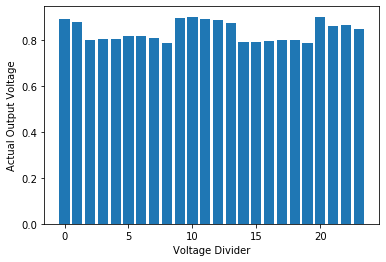

In [12]:
plt.bar(range(Vout_act.size), Vout_act)
plt.ylabel("Actual Output Voltage")
plt.xlabel("Voltage Divider");

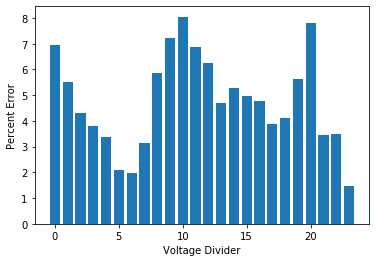

In [13]:
percent_error = 100 * np.abs((Vout_act - Vout) / Vout)
plt.bar(range(percent_error.size), percent_error)
plt.ylabel("Percent Error")
plt.xlabel("Voltage Divider");

The best resistor divider is:

In [14]:
best = percent_error.argmin()
best

23

This resistor divider is composed of resistors with values:

In [15]:
print(f"{R1[best]} and {R2[best]} ohms")

22000.0 and 8200.0 ohms


It results in an output voltage of:

In [16]:
Vout_act[best]

0.8455193100862393

Which has a percent error of:

In [17]:
print(f"{percent_error[best]}%")

1.462317210348707%
